In this project we will create a model to predict on a motion discrimination dataset. The model consists of two 2D convolutional LSTM layer followed by a flattening layer and 3 fully connected layers. The dataset used for training and testing consists of thousands of short videos with a black background. There are white dots on the screen which will move either left or right. The model's task is to determine which direction the dots are moving in the video. We will use the keras framework from the Tensorflow library to build, train and evaluate the performance of this model. We will use numpy and pandas libraries for working with our dataset and preparing the examples for training and testing. We use the cv2 library for reading in the frame data from the video files. Finally, we will use google drive to store folders of the data.

In [1]:
from tensorflow import keras
from keras.layers import BatchNormalization, Dense, MaxPooling3D, Flatten, Conv2D, Reshape, ConvLSTM2D, LeakyReLU, Dropout
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The root path will be used to access the data. Please change this to the path in which this file resides. 

In [2]:
root_path = 'gdrive/My Drive/Colab Notebooks/Research'  #change root_path to your project folder, where the .ipynb file is stored

The IMG_SIZE is a constant that determines the dimmension to which the frames of the video will be cropped. For example, IMG_SIZE = 32 will result in a frame shape of 32x32. BATCH_SIZE is a constant that will break the training data into batches of that size. EPOCHS is a constant that determines the number of iterations for which the model will be trained. MAX_SEQ_LENGTH is a variable that cuts the number of frames down to its value. For example, if a video file containing a video with 30 frames is input then the total number of frames for that example will be cropped to the first MAX_SEQ_LENGTH number of frames. This helps reduce the amount of RAM used and the runtime. 

In [3]:
IMG_SIZE = 32 #represents the height and width of the frame
BATCH_SIZE = 8
EPOCHS =10

MAX_SEQ_LENGTH = 10 #represents the number of frames 
num_models = 3 #number of models that are trained and returned when calling get_models() 

This cell reads the data into two different data frames: train_df and test_df. These dataframes contain the filenames for all of the training and testing video examples. 

In [4]:
data_path = root_path + "/Data2/train/DataFile2.csv"
test_data_path = root_path + "/Data2/test/TestData2File.csv"
train_df = pd.read_csv(data_path)
test_df = pd.read_csv(test_data_path)

# shuffle the DataFrame rows
train_df = train_df.sample(frac = 1)
test_df = test_df.sample(frac = 1)    




print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 2000
Total videos for testing: 686


,file_name,label
361,test1472.avi,Right
1160,test2271.avi,Left
1638,test2749.avi,Left
1572,test2683.avi,Left
226,test1337.avi,Right
678,test1789.avi,Right
1695,test27106.avi,Left
475,test1586.avi,Right
405,test1516.avi,Right
95,test11106.avi,Right


The crop_center_square function takes in a frame as an argument and outputs an array containing the the center of the frame. The load_video function takes in the path or filename of an example, the maximum frames the processed example should have, and what shape to form the example into. This function will return a numpy array containing the rgb values of a specific video example. The numpy output shape is (MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3).

In [5]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    path = root_path +"/Data2/" + path
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

This cell converts the y-values (either "Left" or "Right") to binary representations.

In [6]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["label"])
)
print(label_processor.get_vocabulary())

['Left', 'Right']


The prepare_all_videos function loads in the dataset from a dataframe and returns the x-values (a numpy array of shape (number of examples, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3)) and the y-values (a numpy array of shape (number of examples, 1). 

In [7]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    print("num_samples:", num_samples)
    video_paths = df["file_name"].values.tolist()
    labels = df["label"].values
    labels = label_processor(labels[..., None]).numpy() #now labels is a binary numpy array with values representing right and left

    
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype="float32"
    )
    

    # For each video.
    for idx, path in enumerate(video_paths):
        video = load_video(os.path.join(root_dir, path))
        if idx%100 == 0:
          print(idx)


        for i, frame in enumerate(video): #this will take the first MAX_SEQ_LENGTH number of frames and return the new numpy array representing the video
          if i < MAX_SEQ_LENGTH:
            frame_features[idx, i] = video[i]
          else:
            break
        

    return frame_features, labels





The build_CNN_RNN function creates a keras sequential model consisting of 8 layers. The first layer is a 2 dimensional convolutional LSTM layer with 8 filters and a kernel size of 3x3. Next, there is a layer that adds non-linearity to the model. These two layers are then repeated again. Next, is a flattening layer that outputs a vector of values for the following dense layer. The first dense layer has 32 neurons and the second dense layer has 16 neurons. Both of these fully connected layers have a relu activation function. The final layer is a dense layer with 2 neurons and a softmax activation function. This cell builds the model and prints the model summary. 

In [8]:
def build_CNN_RNN():
  model = keras.Sequential()


  model.add(ConvLSTM2D(8, kernel_size=(3,3), padding='same', return_sequences=True, input_shape=(MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3)))
  model.add(LeakyReLU())
  model.add(ConvLSTM2D(8, kernel_size=(3,3), padding='same', return_sequences=False))
  model.add(LeakyReLU())
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(2,activation='softmax'))
  return model
model = build_CNN_RNN()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 10, 32, 32, 8)     3200      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10, 32, 32, 8)     0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 32, 32, 8)         4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 8)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 dense_1 (Dense)             (None, 16)                5

In [9]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


This cell compiles the model, sets the learning rate and optimizer, and fits the model to the training data. The model is then evaluated using the testing data. 

In [10]:
# Compile the model
def compile_model(my_model, train_data, train_labels):
  my_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=.01),
              metrics=['accuracy']) #passes in parameters required to define the model

  filepath = "/tmp/video_classifier"
  checkpoint = keras.callbacks.ModelCheckpoint(
          filepath, save_weights_only=True, save_best_only=True, verbose=1
      ) # if you would like to save the weights of the best model during training then you can uncomment the line in history below

  # Fit data to model
  history = my_model.fit(train_data,
          train_labels,
          batch_size=BATCH_SIZE,
          validation_split=0.3,
          epochs=EPOCHS,
          # checkpoints=[checkpoint]
          )
  return my_model

The get_models function manages the calls to compile and build more models. The purpose of this function is to be able to pass in how many trained models are required (num_models) as well as the training data and labels and this function will return a list of the models.

In [11]:
def get_models(num_models, train_data, train_labels):
  models = [] #a list of length num_models that contains all of the models trained on a specific MAX_SEQ_LENGTH value
  for i in range(num_models):
    built_model = build_CNN_RNN()
    comp_model = compile_model(built_model, train_data, train_labels)
    models.append(comp_model)
  return models




A new noisy test set is loaded into a pandas dataframe. The noisy test set has a lower correlation value. This means that a smaller percentage of the dots on the screen in a given example are actually moving the labeled direction (either left or right).

In [12]:
noise_data_path = root_path + "/Data2/noise_data/NoiseDataFile.csv"
noise_df = pd.read_csv(noise_data_path)

# shuffle the DataFrame rows
noise_df = noise_df.sample(frac = 1)


print(f"Total videos for noisy testing: {len(noise_df)}")

noise_df.sample(10)



Total videos for noisy testing: 686


,file_name,label
65,test1233.avi,Right
492,test2413.avi,Left
181,test1457.avi,Right
551,test2526.avi,Left
620,test2655.avi,Left
175,test1451.avi,Right
470,test2352.avi,Left
526,test2462.avi,Left
681,test2773.avi,Left
179,test1455.avi,Right


This cell contains much of the computation of the document. Performance is a numpy array that contains performance data on 15 different models. This cell starts by assigning a value to MAX_SEQ_LENGTH starting with 1 and going to 5. Then, the training data and labels as well as the noisy data and labels for testing are loaded. The datasets need to be reloaded each time because this will change the shape of the numpy arrays. Scores is an array that contains the performance for the models that are trained on a specific MAX_SEQ_LENGTH number. Each of the three models are trained on the training data set (which has been cropped to the correct number of frames). Each of the three models performances on the noisy data set are saved in the performance array. Then, the MAX_SEQ_LENGTH value is increased and the process is repeated. This continues until three models are trained for five different values for number of frames (MAX_SEQ_LENGTH values). Next, a graph is created to show how the number of frames in a video impacts the algorithm's performance on the motion discrimination problem. The number of frames in the data videos are plotted on the x-axis and the average of the three models' performance is graphed on the y-axis. This cell can be expected to take 1-2 hours to finish running if you are using collab pro. 

num_samples: 2000
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
num_samples: 686
0
100
200
300
400
500
600
Frame features in train set: (2000, 1, 32, 32, 3)
Frame features in train set: (2000, 1)
Epoch 1/10
175/175 [==============================] - 15s 15ms/step - loss: 0.7003 - accuracy: 0.4736 - val_loss: 0.6910 - val_accuracy: 0.5183
Epoch 2/10
175/175 [==============================] - 2s 12ms/step - loss: 0.6845 - accuracy: 0.5636 - val_loss: 0.7011 - val_accuracy: 0.5150
Epoch 3/10
175/175 [==============================] - 2s 12ms/step - loss: 0.5900 - accuracy: 0.6900 - val_loss: 0.9030 - val_accuracy: 0.5033
Epoch 4/10
175/175 [==============================] - 2s 12ms/step - loss: 0.4238 - accuracy: 0.7814 - val_loss: 1.3644 - val_accuracy: 0.4917
Epoch 5/10
175/175 [==============================] - 2s 12ms/step - loss: 0.2688 - accuracy: 0.8800 - val_loss: 1.2935 - val_accuracy: 0.4983
Epoch 6/10
175/175 [==========================

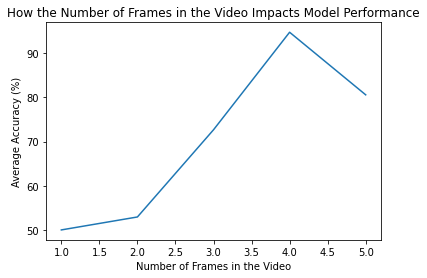

In [13]:
performance = np.zeros((5,3)) #contains the performance of 3 models for each of the 5 values of MAX_SEQ_LENGTH. Performance is on the noisy dataset
for length in range(1,6):
  MAX_SEQ_LENGTH = length
  train_data, train_labels = prepare_all_videos(train_df, "train")
  noise_data, noise_labels = prepare_all_videos(noise_df, "noise_data")
  print(f"Frame features in train set: {train_data.shape}")
  print(f"Frame features in train set: {train_labels.shape}")


  



  scores = np.zeros((3))
  eval_models = get_models(num_models, train_data, train_labels)
  for i in range(len(eval_models)):
    score = eval_models[i].evaluate(noise_data, noise_labels, verbose=0)
    scores[i] = (round((score[1]*100),3))
  performance[length-1] = scores
  print("performance update:", performance)
  
plt.plot(np.array(range(1,6)), np.average(performance,axis=1))
plt.title('How the Number of Frames in the Video Impacts Model Performance')
plt.ylabel('Average Accuracy (%)')
plt.xlabel('Number of Frames in the Video')
plt.show()
  

